In [ ]:
!pip install qiskit

In [ ]:
pip install qiskit-algorithms

In [ ]:
!pip install qiskit-machine-learning

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

In [5]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [6]:
# Define the data transformation (the one you provided)
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Initialize variables to accumulate the sum of pixel values and the sum of squared pixel values
sum_R, sum_G, sum_B = 0, 0, 0
sum_squared_R, sum_squared_G, sum_squared_B = 0, 0, 0

# Loop through the training dataset to calculate the sums
for data in trainset:
    image, _ = data
    R, G, B = image[0].numpy(), image[1].numpy(), image[2].numpy()
    sum_R += np.sum(R)
    sum_G += np.sum(G)
    sum_B += np.sum(B)
    sum_squared_R += np.sum(R ** 2)
    sum_squared_G += np.sum(G ** 2)
    sum_squared_B += np.sum(B ** 2)

# Calculate the mean and standard deviation for each channel
num_samples = len(trainset)
mean_R = sum_R / (num_samples * 32 * 32)
mean_G = sum_G / (num_samples * 32 * 32)
mean_B = sum_B / (num_samples * 32 * 32)
std_R = np.sqrt((sum_squared_R / (num_samples * 32 * 32)) - mean_R**2)
std_G = np.sqrt((sum_squared_G / (num_samples * 32 * 32)) - mean_G**2)
std_B = np.sqrt((sum_squared_B / (num_samples * 32 * 32)) - mean_B**2)

# Print the calculated mean and standard deviation values
print(f"Mean (R, G, B): ({mean_R}, {mean_G}, {mean_B})")
print(f"Standard Deviation (R, G, B): ({std_R}, {std_G}, {std_B})")

100%|██████████| 170498071/170498071 [00:04<00:00, 39267161.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Mean (R, G, B): (0.4913996928841993, 0.4821584227318875, 0.4465309281962551)
Standard Deviation (R, G, B): (0.2470322327408621, 0.24348512830290878, 0.26158784048637423)


In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean_R, mean_G, mean_B), (std_R, std_G, std_B))]) #Normalizza i data, centralizzati con la media a 0  e la dev std a 1 in modo da dare la stessa importanza a tutti i dati


In [8]:
batch_size = 64
lr = 0.01
epochs = 4

In [9]:



trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [21]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms


In [61]:
# Define the classes you want to keep
desired_classes = ['airplane', 'automobile']  # Example: Keep only 'airplane' and 'automobile' classes

# Load the CIFAR-10 dataset with specified transformations
full_trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Initialize lists to store indices of samples for each class
indices_airplane = []
indices_automobile = []

# Collect indices for desired classes
for i in range(len(full_trainset)):
    label = full_trainset.targets[i]
    class_name = full_trainset.classes[label]
    if class_name == 'airplane' and len(indices_airplane) < 200:
        indices_airplane.append(i)
    elif class_name == 'automobile' and len(indices_automobile) < 200:
        indices_automobile.append(i)

# Combine indices for both classes
indices = indices_airplane + indices_automobile

# Create Subset with limited samples for training
trainset = torch.utils.data.Subset(full_trainset, indices)

# Create DataLoader for training set
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)



Files already downloaded and verified


In [62]:
# Define a set to store unique class labels
unique_classes = set()

# Iterate over the trainset and collect unique class labels
for _, label in trainset:
    unique_classes.add(label)

# Print the unique class labels
print("Classes present in trainset:")
for class_label in sorted(unique_classes):
    print(class_label)

Classes present in trainset:
0
1


In [63]:
len(trainset)

400

In [64]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2) #set batch_size to 1 to print the next cell uncomment to print the images


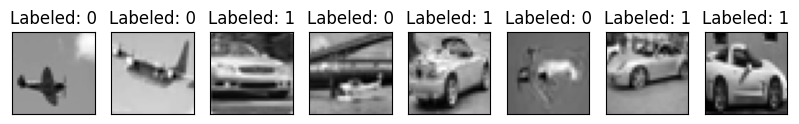

In [17]:
n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
    #axes[n_samples_show - 1].imshow( tf.shape( tf.squeeze(images[0]) ),cmap='gray' )
    #plt.imshow((tf.squeeze(images[0])))

    #plt.imshow( tf.shape( tf.squeeze(x_train) ) )
    #axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))

    n_samples_show -= 1

In [65]:
# Load the CIFAR-10 test dataset
full_testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Initialize lists to store indices of samples for each class
indices_airplane = []
indices_automobile = []

# Collect indices for desired classes
for i in range(len(full_testset)):
    label = full_testset.targets[i]
    class_name = full_testset.classes[label]
    if class_name == 'airplane' and len(indices_airplane) < 40:
        indices_airplane.append(i)
    elif class_name == 'automobile' and len(indices_automobile) < 40:
        indices_automobile.append(i)

# Combine indices for both classes
indices = indices_airplane + indices_automobile

# Create Subset with limited samples for training
testset = torch.utils.data.Subset(full_testset, indices)

# Create DataLoader for training set
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)


Files already downloaded and verified


In [ ]:
# test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, num_workers=2)

In [66]:
# Define a set to store unique class labels
unique_classes = set()

# Iterate over the trainset and collect unique class labels
for _, label in testset:
    unique_classes.add(label)

# Print the unique class labels
print("Classes present in testset:")
for class_label in sorted(unique_classes):
    print(class_label)

Classes present in testset:
0
1


In [72]:
len(testset)

80

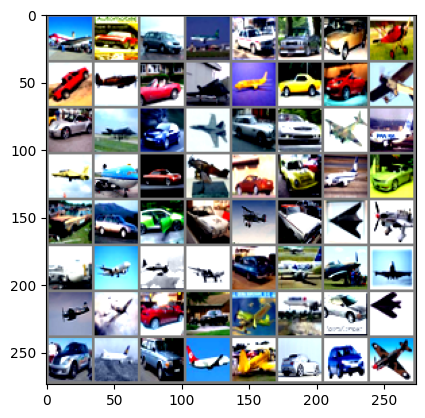

frog  truck truck frog  truck truck truck frog  truck frog  truck frog  frog  truck truck frog  truck frog  truck frog  truck truck frog  frog  frog  frog  truck frog  truck truck frog  truck truck truck truck truck frog  truck frog  frog  frog  frog  frog  frog  truck frog  frog  frog  frog  frog  truck truck frog  frog  truck frog  truck frog  truck frog  frog  truck truck frog 


In [ ]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # le uscite cosi si chiamano logits (quelle che abbiamo prima della softmax)
        return x


net = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [11]:
import torch.optim as optim

In [12]:
criterion = nn.CrossEntropyLoss() # fa la softmax cross-entropy loss in un solo colpo e viene chiamato criterion
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

In [70]:
  for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [71]:
#with the mean and std calculate on the data

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        labels = labels.to(device)
        images = images.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 80 test images: {100 * correct // total} %')

Accuracy of the network on the 80 test images: 80 %


In [35]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in desired_classes}
total_pred = {classname: 0 for classname in desired_classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        labels = labels.to(device)
        images = images.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[desired_classes[label]] += 1
            total_pred[desired_classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 86.7 %
Accuracy for class: car   is 80.0 %


In [36]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import Subset, DataLoader

# Define the classes you want to keep
desired_classes = ['cat', 'dog']

# Load the CIFAR-10 dataset with specified transformations
full_trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Initialize lists to store indices of samples for each class
indices_cat = []
indices_dog = []

# Collect indices for desired classes and swap labels
for i in range(len(full_trainset)):
    label = full_trainset.targets[i]
    class_name = full_trainset.classes[label]
    if class_name == 'cat' and len(indices_cat) < 200:
        full_trainset.targets[i] = 0  # Swap label of cat with airplane (0)
        indices_cat.append(i)
    elif class_name == 'dog' and len(indices_dog) < 200:
        full_trainset.targets[i] = 1  # Swap label of dog with automobile (1)
        indices_dog.append(i)

# Combine indices for both classes
indices = indices_cat + indices_dog

# Create Subset with limited samples for training
trainset = Subset(full_trainset, indices)

# Create DataLoader for training set
batch_size = 64  # Example batch size
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)


Files already downloaded and verified


In [37]:
# Define a set to store unique class labels
unique_classes = set()

# Iterate over the trainset and collect unique class labels
for _, label in trainset:
    unique_classes.add(label)

# Print the unique class labels
print("Classes present in trainset:")
for class_label in sorted(unique_classes):
    print(class_label)

Classes present in trainset:
0
1


In [38]:
len(trainset)

400

In [16]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)


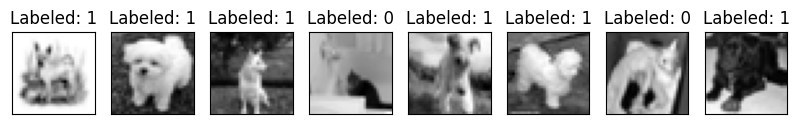

In [17]:
n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
    #axes[n_samples_show - 1].imshow( tf.shape( tf.squeeze(images[0]) ),cmap='gray' )
    #plt.imshow((tf.squeeze(images[0])))

    #plt.imshow( tf.shape( tf.squeeze(x_train) ) )
    #axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))

    n_samples_show -= 1

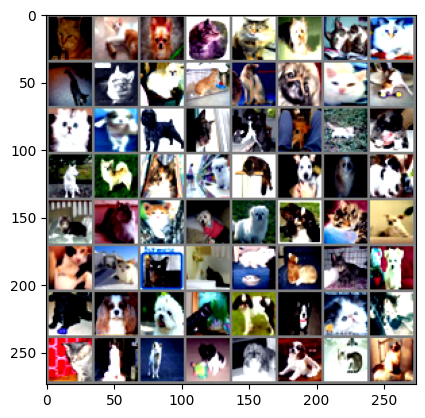

cat   cat   dog   cat   cat   dog   cat   cat   cat   cat   dog   cat   cat   dog   cat   dog   cat   dog   dog   cat   dog   dog   cat   dog   dog   dog   cat   dog   cat   dog   dog   dog   cat   cat   cat   dog   dog   dog   cat   dog   cat   cat   cat   cat   cat   cat   cat   dog   dog   dog   dog   cat   dog   dog   cat   cat   cat   cat   dog   dog   dog   dog   cat   cat  


In [13]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{desired_classes[labels[j]]:5s}' for j in range(batch_size)))

In [39]:
# Load the CIFAR-10 test dataset
full_testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Initialize lists to store indices of samples for each class
indices_cat = []
indices_dog = []

# Collect indices for desired classes
for i in range(len(full_testset)):
    label = full_testset.targets[i]
    class_name = full_testset.classes[label]
    if class_name == 'cat' and len(indices_cat) < 40:
        full_testset.targets[i] = 0  # Swap label of cat with airplane (0)
        indices_cat.append(i)
    elif class_name == 'dog' and len(indices_dog) < 40:
        full_testset.targets[i] = 1  # Swap label of dog with automobile (1)
        indices_dog.append(i)

# Combine indices for both classes
indices = indices_cat + indices_dog

# Create Subset with limited samples for training
testset = torch.utils.data.Subset(full_testset, indices)

# Create DataLoader for training set
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


In [40]:
# Define a set to store unique class labels
unique_classes = set()

# Iterate over the trainset and collect unique class labels
for _, label in testset:
    unique_classes.add(label)

# Print the unique class labels
print("Classes present in testset:")
for class_label in sorted(unique_classes):
    print(class_label)

Classes present in testset:
0
1


In [41]:
len(testset)

80

In [42]:
net = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [43]:
criterion = nn.CrossEntropyLoss() # fa la softmax cross-entropy loss in un solo colpo e viene chiamato criterion
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

In [44]:
  for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [45]:
#with the mean and std calculate on the data

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        labels = labels.to(device)
        images = images.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 80 test images: {100 * correct // total} %')

Accuracy of the network on the 80 test images: 57 %


In [46]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in desired_classes}
total_pred = {classname: 0 for classname in desired_classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        labels = labels.to(device)
        images = images.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[desired_classes[label]] += 1
            total_pred[desired_classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cat   is 87.5 %
Accuracy for class: dog   is 27.5 %


In [24]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import Subset, DataLoader

# Define the classes you want to keep
desired_classes = ['ship', 'truck']

# Load the CIFAR-10 dataset with specified transformations
full_trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Initialize lists to store indices of samples for each class
indices_ship = []
indices_truck = []

# Collect indices for desired classes and swap labels
for i in range(len(full_trainset)):
    label = full_trainset.targets[i]
    class_name = full_trainset.classes[label]
    if class_name == 'ship' and len(indices_ship) < 200:
        full_trainset.targets[i] = 0  # Swap label of cat with airplane (0)
        indices_ship.append(i)
    elif class_name == 'truck' and len(indices_truck) < 200:
        full_trainset.targets[i] = 1  # Swap label of dog with automobile (1)
        indices_truck.append(i)

# Combine indices for both classes
indices = indices_ship + indices_truck

# Create Subset with limited samples for training
trainset = Subset(full_trainset, indices)

# Create DataLoader for training set
batch_size = 64 # Example batch size
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


In [25]:
# Define a set to store unique class labels
unique_classes = set()

# Iterate over the trainset and collect unique class labels
for _, label in trainset:
    unique_classes.add(label)

# Print the unique class labels
print("Classes present in trainset:")
for class_label in sorted(unique_classes):
    print(class_label)

Classes present in trainset:
0
1


In [26]:
len(trainset)

400

In [27]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)


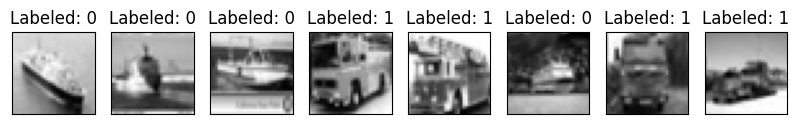

In [38]:
n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
    #axes[n_samples_show - 1].imshow( tf.shape( tf.squeeze(images[0]) ),cmap='gray' )
    #plt.imshow((tf.squeeze(images[0])))

    #plt.imshow( tf.shape( tf.squeeze(x_train) ) )
    #axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))

    n_samples_show -= 1

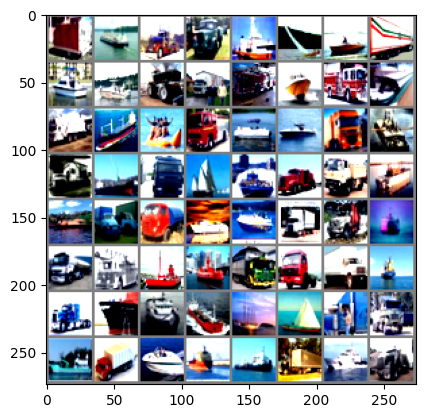

truck ship  truck truck ship  ship  ship  truck ship  ship  truck truck truck ship  truck ship  truck ship  ship  truck ship  ship  truck ship  truck ship  truck ship  ship  truck truck ship  ship  truck truck ship  ship  truck truck ship  truck truck ship  ship  truck truck truck ship  truck ship  ship  ship  ship  ship  truck truck ship  truck ship  ship  ship  truck ship  truck


In [34]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{desired_classes[labels[j]]:5s}' for j in range(batch_size)))

In [28]:
# Load the CIFAR-10 test dataset
full_testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Initialize lists to store indices of samples for each class
indices_ship = []
indices_truck = []

# Collect indices for desired classes
for i in range(len(full_testset)):
    label = full_testset.targets[i]
    class_name = full_testset.classes[label]
    if class_name == 'ship' and len(indices_ship) < 40:
        full_testset.targets[i] = 0  # Swap label of cat with airplane (0)
        indices_ship.append(i)
    elif class_name == 'truck' and len(indices_truck) < 40:
        full_testset.targets[i] = 1  # Swap label of dog with automobile (1)
        indices_truck.append(i)

# Combine indices for both classes
indices = indices_ship + indices_truck

# Create Subset with limited samples for training
testset = torch.utils.data.Subset(full_testset, indices)

# Create DataLoader for training set
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


In [29]:
# Define a set to store unique class labels
unique_classes = set()

# Iterate over the trainset and collect unique class labels
for _, label in testset:
    unique_classes.add(label)

# Print the unique class labels
print("Classes present in testset:")
for class_label in sorted(unique_classes):
    print(class_label)

Classes present in testset:
0
1


In [30]:
len(testset)

80

In [31]:
net = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [32]:
criterion = nn.CrossEntropyLoss() # fa la softmax cross-entropy loss in un solo colpo e viene chiamato criterion
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

In [33]:
  for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [34]:
#with the mean and std calculate on the data

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        labels = labels.to(device)
        images = images.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 80 test images: {100 * correct // total} %')

Accuracy of the network on the 80 test images: 85 %


In [35]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in desired_classes}
total_pred = {classname: 0 for classname in desired_classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        labels = labels.to(device)
        images = images.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[desired_classes[label]] += 1
            total_pred[desired_classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: ship  is 87.5 %
Accuracy for class: truck is 82.5 %
